Data set is from Box & Jenkins airline data - described by many other data providers such as Kaggle, Github as Monthly totals of international airline passengers, 1949 to 1960. Figures are in thousands. (It may be US Airline international passengers.)

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
# Dataset 'Airline-passengers.csv'
data = pd.read_csv('Airline-passengers.csv') 
data= data.dropna()
## convert no. of passengers to ln(no. of passengers) - model this "more stationary" series
data['lnair'] = np.log(data['Passengers'])
print(data)

       Month  Passengers     lnair
0    1949-01         112  4.718499
1    1949-02         118  4.770685
2    1949-03         132  4.882802
3    1949-04         129  4.859812
4    1949-05         121  4.795791
..       ...         ...       ...
139  1960-08         606  6.406880
140  1960-09         508  6.230481
141  1960-10         461  6.133398
142  1960-11         390  5.966147
143  1960-12         432  6.068426

[144 rows x 3 columns]


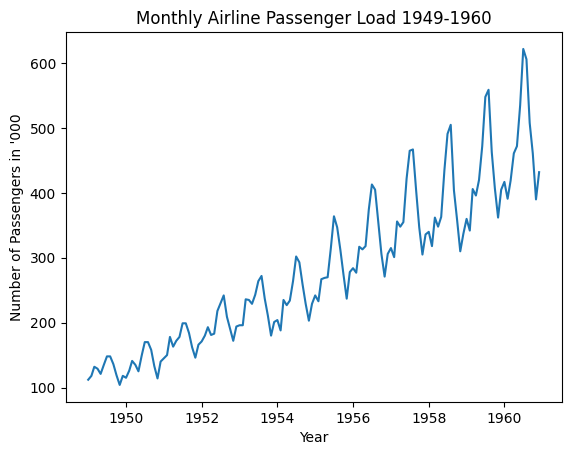

In [4]:
### See time series plot
dataframe = pd.DataFrame(data,columns=['Month', 'Passengers'])
# Changing the datatype
dataframe["Month"] = dataframe["Month"].astype("datetime64[ns]")
 # Setting the Date as index
dataframe = dataframe.set_index("Month")
dataframe 

# Import Library
import matplotlib.pyplot as plt
# Plot
plt.plot(dataframe["Passengers"], marker='')

# Labelling 
plt.xlabel("Year")
plt.ylabel("Number of Passengers in '000")
plt.title("Monthly Airline Passenger Load 1949-1960")

# Display
plt.show()  

# There appears to be a 12-month seasonality

Airline Passenger Load


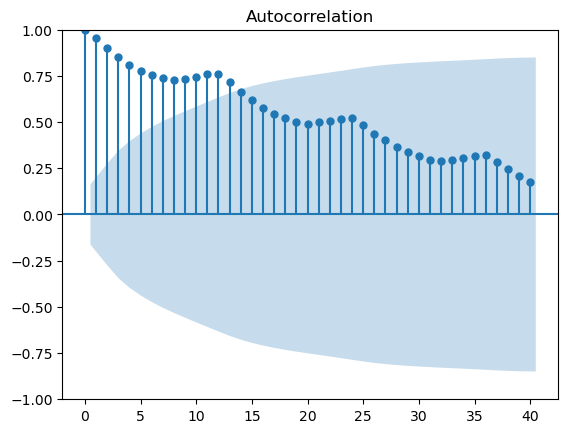

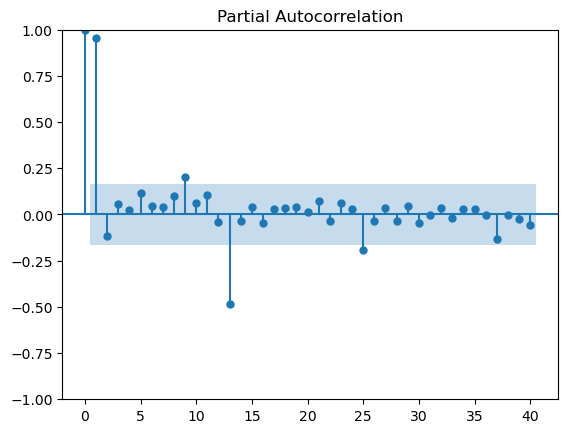

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print('Airline Passenger Load')

plot_acf(data['lnair'], lags=40);
plot_pacf(data['lnair'], method='ywm', lags=40);

In [5]:
lnair12 = data['lnair']-data['lnair'].shift(12) ##.shift(12) means to subtract from 12 mths earlier
lnair12.head(20)
### integrating also induces stationarity for ARMA estimation usu using Maximum Likelihood method

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12    0.026433
13    0.065597
14    0.065958
15    0.045462
16    0.032523
17    0.098672
18    0.138586
19    0.138586
Name: lnair, dtype: float64

In [6]:
data['lnair12'] =lnair12  ### put lnair12 into data with indexing
print(data)

       Month  Passengers     lnair   lnair12
0    1949-01         112  4.718499       NaN
1    1949-02         118  4.770685       NaN
2    1949-03         132  4.882802       NaN
3    1949-04         129  4.859812       NaN
4    1949-05         121  4.795791       NaN
..       ...         ...       ...       ...
139  1960-08         606  6.406880  0.080731
140  1960-09         508  6.230481  0.092754
141  1960-10         461  6.133398  0.124585
142  1960-11         390  5.966147  0.074503
143  1960-12         432  6.068426  0.064539

[144 rows x 4 columns]


Airline Passenger Load - Seasonal Differencing


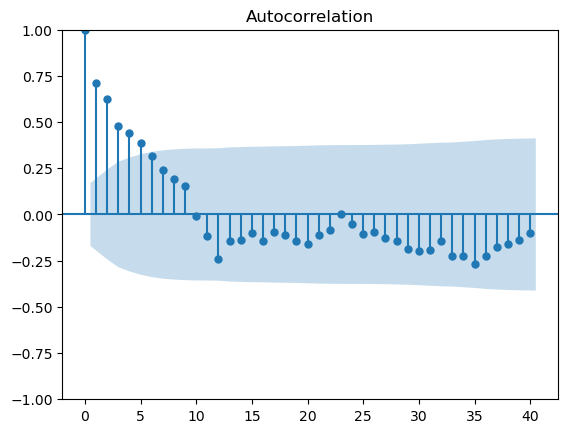

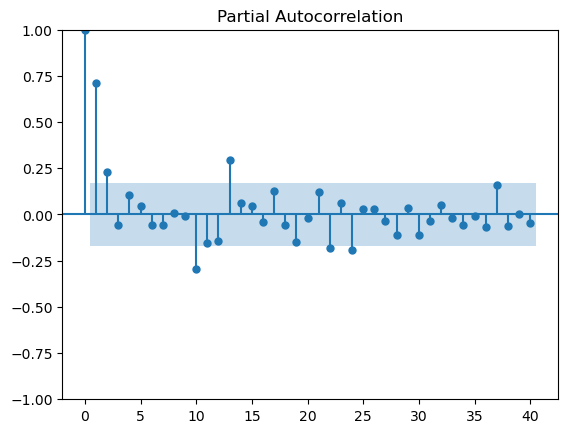

In [7]:
lnair12 = data['lnair12'].dropna()

print('Airline Passenger Load - Seasonal Differencing')
plot_acf(lnair12.dropna(), lags=40);
plot_pacf(lnair12.dropna(), method='ywm', lags=40);

In [8]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['10%']
    if (pvalue < 0.10) and (adf < critical_value):   ### and because statsmodel adfuller p-value is not as accurate
        print('The series is stationary, reject null at 10% significance level')
    else:
        print('The series is NOT stationary, do not reject null at 10% significance level')

In [9]:
### check statonarity of lnair12
print('ADF Statistic: %f' % adfuller(lnair12)[0])
print('p-value: %f' % adfuller(lnair12)[1])
check_stationarity(lnair12)

ADF Statistic: -2.709577
p-value: 0.072396
The series is stationary, reject null at 10% significance level


Documentation for an example of 
statsmodels.tsa.statespace.sarimax.SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)

In [10]:
### Apply (1,0,1) x (0,1,0)_12 
import statsmodels.api as sm
model0 = sm.tsa.statespace.SARIMAX(data['lnair'], order=(1,0,1), seasonal_order=(0, 1, 0, 12))  
model0_fit=model0.fit(disp=0)
print(model0_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               lnair   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                 228.678
Date:                             Sat, 30 Dec 2023   AIC                           -451.355
Time:                                     12:07:47   BIC                           -442.707
Sample:                                          0   HQIC                          -447.841
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9768      0.017     56.238      0.000       0.943       1.011
ma.L1         -0.3739      

In [11]:
### Apply (1,0,1) directly to lnair12 -- avoid initial 12 obs null in fitting later
### Results slightly diff cos internally treating NA in first 12 obs is a bit different
import statsmodels.api as sm
model1 = sm.tsa.statespace.SARIMAX(data['lnair12'], trend='c', order=(1,0,1))  
model1_fit=model1.fit(disp=0)
print(model1_fit.summary())
### constant c is added

                               SARIMAX Results                                
Dep. Variable:                lnair12   No. Observations:                  144
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 232.589
Date:                Sat, 30 Dec 2023   AIC                           -457.177
Time:                        12:07:47   BIC                           -445.298
Sample:                             0   HQIC                          -452.350
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0164      0.007      2.261      0.024       0.002       0.031
ar.L1          0.8569      0.057     15.035      0.000       0.745       0.969
ma.L1         -0.2848      0.103     -2.767      0.0

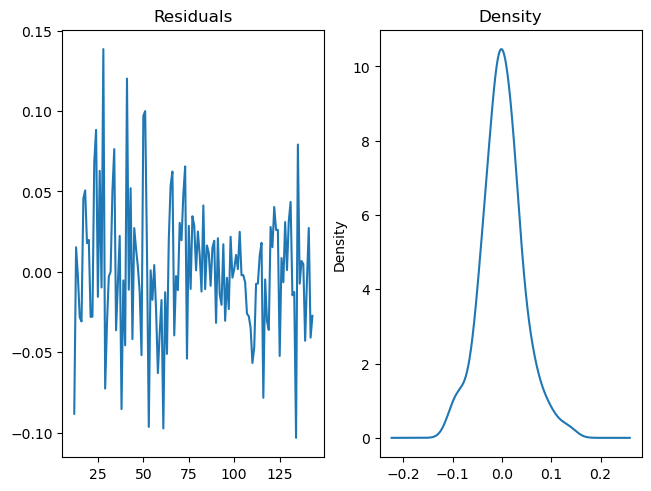

In [12]:
### Plot residual errors
### See https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
residuals1 = model1_fit.resid
fig,ax = plt.subplots(1,2,constrained_layout = True)
residuals1.plot(title="Residuals", ax=ax[0])
residuals1.plot(kind='kde',title='Density',ax=ax[1])
plt.show()
##resi=pd.DataFrame(model1_fit.resid)  ### convert back to pandas df

In [13]:
predictions1 = model1.fit().predict()  ### Note: 'predict' is just fitting here
print(predictions1)
err1=abs(predictions1-lnair12.dropna())
print(err1.dropna())
err1na=err1.dropna()
print("mean abs error =", np.sum(err1na)/err1na.size)

0      0.114642
1      0.114642
2      0.114642
3      0.114642
4      0.114642
         ...   
139    0.123569
140    0.097786
141    0.097320
142    0.115396
143    0.091895
Name: predicted_mean, Length: 144, dtype: float64
12     0.088209
13     0.015278
14     0.002494
15     0.028172
16     0.030863
         ...   
139    0.042838
140    0.005032
141    0.027264
142    0.040893
143    0.027357
Length: 132, dtype: float64
mean abs error = 0.031250891224000564


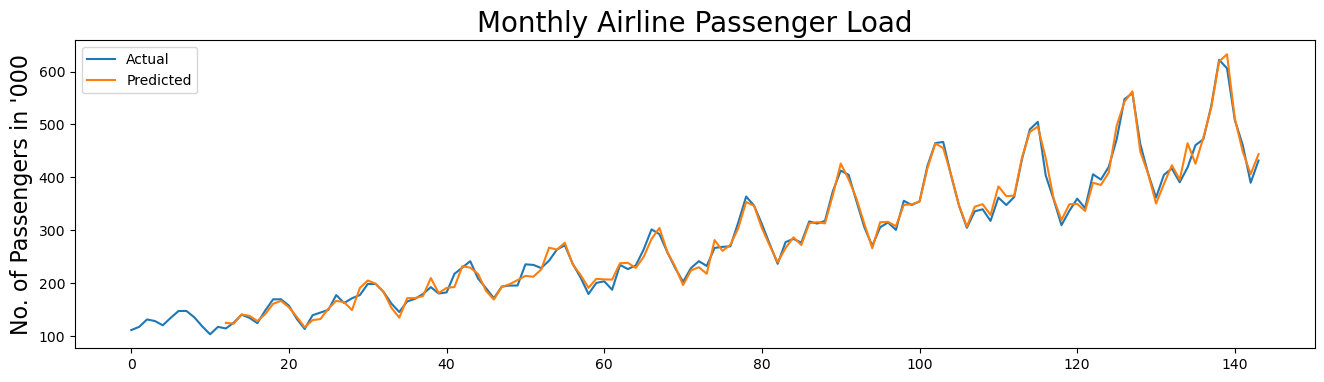

In [14]:
predict1=predictions1 + data['lnair'].shift(12)
## convert ln back to raw levels
Epredict1=np.exp(predict1)
plt.figure(figsize=(16,4))
plt.plot(data['Passengers'], label="Actual")
plt.plot(Epredict1, label="Predicted")
plt.title('Monthly Airline Passenger Load', fontsize=20)
plt.ylabel("No. of Passengers in '000", fontsize=16)
plt.legend()

Predictions able to catch the peaks and troughs

# Now we try other specifications of ARIMA

In [15]:
### Apply (1,0,6) directly to lnair12 -- avoid initial 12 obs null in fitting later
### Results slightly diff cos of 144 vs 132, treating of starting value
import statsmodels.api as sm
model2 = sm.tsa.statespace.SARIMAX(data['lnair12'], trend='c', order=(1,0,6))  
model2_fit=model2.fit(disp=0,maxiter=250)  ## incr maxiter avoids 'nonconverg of ML'
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                lnair12   No. Observations:                  144
Model:               SARIMAX(1, 0, 6)   Log Likelihood                 238.866
Date:                Sat, 30 Dec 2023   AIC                           -459.732
Time:                        12:07:48   BIC                           -433.004
Sample:                             0   HQIC                          -448.871
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0254      0.011      2.220      0.026       0.003       0.048
ar.L1          0.7773      0.085      9.197      0.000       0.612       0.943
ma.L1         -0.2517      0.105     -2.404      0.0

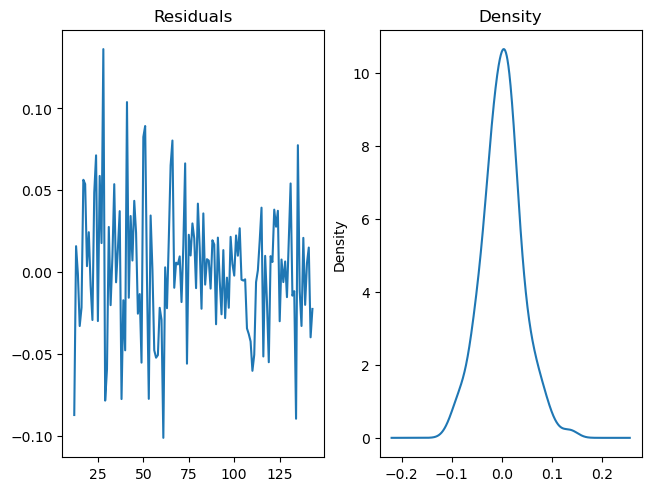

In [16]:
### Plot residual errors
residuals2 = model2_fit.resid
fig,ax = plt.subplots(1,2,constrained_layout = True)
residuals2.plot(title="Residuals", ax=ax[0])
residuals2.plot(kind='kde',title='Density',ax=ax[1])
plt.show()

In [17]:
predictions2 = model2.fit().predict()  ### Note: 'predict' is just fitting here
pd.set_option('display.max_rows', None)  ### print without truncation
print(predictions2)
err2=abs(predictions2-lnair12.dropna())
print(err2.dropna())
err2na=err2.dropna()
print("mean abs error =", np.sum(err2na)/err2na.size)

0      0.113851
1      0.113851
2      0.113851
3      0.113851
4      0.113851
5      0.113851
6      0.113851
7      0.113851
8      0.113851
9      0.113851
10     0.113851
11     0.113851
12     0.113851
13     0.050689
14     0.067921
15     0.078988
16     0.054665
17     0.042995
18     0.085125
19     0.134918
20     0.125426
21     0.119691
22     0.121140
23     0.122628
24     0.160575
25     0.203250
26     0.173171
27     0.170231
28     0.181729
29     0.255252
30     0.215890
31     0.129625
32     0.173038
33     0.186254
34     0.193386
35     0.175270
36     0.149326
37     0.144999
38     0.158145
39     0.121894
40     0.110854
41     0.099365
42     0.160442
43     0.160678
44     0.119556
45     0.121111
46     0.139254
47     0.181472
48     0.149547
49     0.140806
50     0.118701
51     0.171564
52     0.227477
53     0.184289
54     0.103160
55     0.115430
56     0.173395
57     0.151908
58     0.096528
59     0.057427
60     0.069720
61     0.059958
62    -0

C:\Users\kglim\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean absolute error is a abit smaller in (1,0,6) x (0,1,0)_12

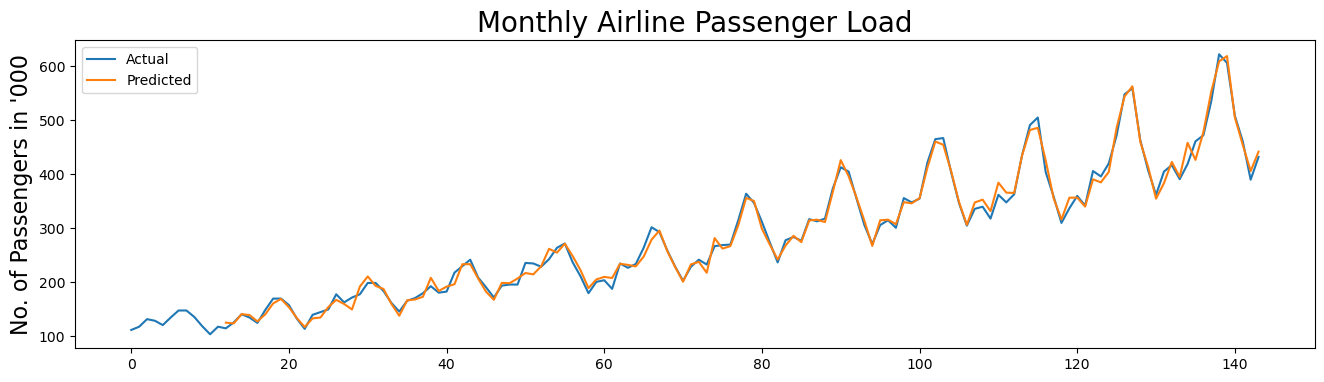

In [18]:
predict2=predictions2 + data['lnair'].shift(12)
## convert ln back to raw levels
Epredict2=np.exp(predict2)
plt.figure(figsize=(16,4))
plt.plot(data['Passengers'], label="Actual")
plt.plot(Epredict2, label="Predicted")
plt.title('Monthly Airline Passenger Load', fontsize=20)
plt.ylabel("No. of Passengers in '000", fontsize=16)
plt.legend()

#Prediction is able to catch the peaks and troughs

# Try 1-month ahead prediction

In [19]:
print(model2_fit.params)

intercept    0.025365
ar.L1        0.777310
ma.L1       -0.251664
ma.L2        0.134292
ma.L3       -0.173373
ma.L4        0.043446
ma.L5        0.169105
ma.L6        0.300331
sigma2       0.001546
dtype: float64



When you set dynamic=True, the model continuously predicts one-step ahead (t+1) and then for the 2nd step ahead (t+2) prediction, it appends predicted value (t+1) to data, re-fits model on new expanded data then makes 2nd step ahead forecast. This is called out-of-sample prediction using predicted explanatory variables

When you set dynamic=False, the model sequentially predicts one-step-ahead using the true value from previous time step instead of using predicted value. This is called out-of-sample prediction using lagged explanatory variables

In [20]:
s=model2_fit.predict(start=0, end=150, exog=None, dynamic=False)
print(s)

0      0.113901
1      0.113901
2      0.113901
3      0.113901
4      0.113901
5      0.113901
6      0.113901
7      0.113901
8      0.113901
9      0.113901
10     0.113901
11     0.113901
12     0.113901
13     0.049819
14     0.067197
15     0.078510
16     0.054264
17     0.042299
18     0.084824
19     0.135032
20     0.125615
21     0.119609
22     0.121173
23     0.122398
24     0.160489
25     0.204366
26     0.174304
27     0.170807
28     0.182905
29     0.256487
30     0.217016
31     0.129989
32     0.172638
33     0.187487
34     0.193727
35     0.176662
36     0.150824
37     0.145120
38     0.158608
39     0.122029
40     0.109890
41     0.098841
42     0.160530
43     0.161421
44     0.120391
45     0.121182
46     0.139928
47     0.181364
48     0.149971
49     0.140597
50     0.118609
51     0.171849
52     0.228848
53     0.186152
54     0.103338
55     0.115404
56     0.173600
57     0.152000
58     0.096276
59     0.057354
60     0.069233
61     0.059751
62    -0

In [21]:
print(predictions2-s)

0     -0.000050
1     -0.000050
2     -0.000050
3     -0.000050
4     -0.000050
5     -0.000050
6     -0.000050
7     -0.000050
8     -0.000050
9     -0.000050
10    -0.000050
11    -0.000050
12    -0.000050
13     0.000869
14     0.000724
15     0.000479
16     0.000401
17     0.000697
18     0.000301
19    -0.000113
20    -0.000189
21     0.000082
22    -0.000033
23     0.000230
24     0.000086
25    -0.001116
26    -0.001134
27    -0.000576
28    -0.001176
29    -0.001235
30    -0.001125
31    -0.000364
32     0.000400
33    -0.001232
34    -0.000341
35    -0.001392
36    -0.001498
37    -0.000121
38    -0.000463
39    -0.000135
40     0.000964
41     0.000524
42    -0.000088
43    -0.000743
44    -0.000836
45    -0.000071
46    -0.000674
47     0.000108
48    -0.000424
49     0.000209
50     0.000092
51    -0.000286
52    -0.001371
53    -0.001863
54    -0.000177
55     0.000027
56    -0.000205
57    -0.000091
58     0.000252
59     0.000073
60     0.000487
61     0.000207
62     0

In [22]:
### shows forward prediction starting at index 144